In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torchvision
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

from sklearn.metrics import accuracy_score ,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

In [6]:
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Load the entire dataset
image_dir = "/content/drive/MyDrive/cell_images"
full_dataset = datasets.ImageFolder(image_dir)

# Split the dataset into train and test sets
train_indices, test_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)

# Create subsets for train and test
train_subset = torch.utils.data.Subset(full_dataset, train_indices)
test_subset = torch.utils.data.Subset(full_dataset, test_indices)

# Apply transformations to train and test subsets
train_subset.dataset.transform = transform
test_subset.dataset.transform = transform

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=False)

# Check the number of images in train and test sets
print("Number of images in train set:", len(train_subset))
print("Number of images in test set:", len(test_subset))

Number of images in train set: 22046
Number of images in test set: 5512


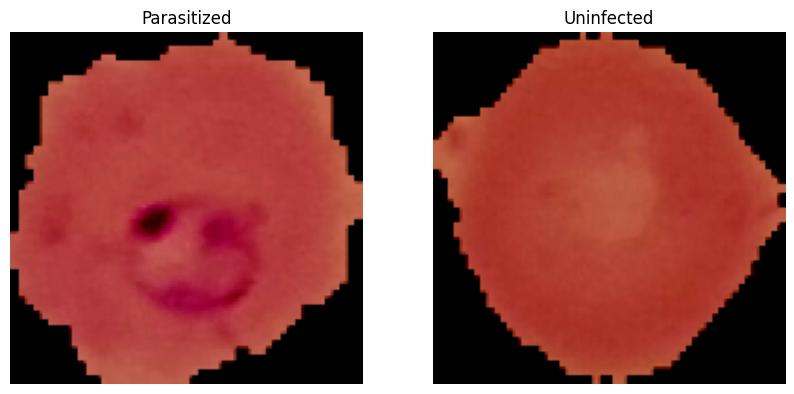

In [9]:
class_names = full_dataset.classes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, class_name in enumerate(class_names):
    # Find an image in the current class
    for img, label in full_dataset:
        if label == i:
            ax = axes[i]
            ax.set_title(class_name)
            ax.imshow(img.permute(1, 2, 0))  # Convert from PyTorch format to image format
            ax.axis('off')
            break  # Break after finding one image per class

plt.show()

Epoch 1, Loss: 0.3079971835849853
Epoch 2, Loss: 0.14406437870974725
Epoch 3, Loss: 0.12790465641074716
Epoch 4, Loss: 0.11444546504105686
Epoch 5, Loss: 0.1050680898284034
Epoch 6, Loss: 0.09103296141387525
Epoch 7, Loss: 0.07896023567567251
Epoch 8, Loss: 0.055283887290864836
Epoch 9, Loss: 0.047725694560708076
Epoch 10, Loss: 0.04367600527544018
Finished Training
Accuracy: 0.9566
Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.96      0.95      0.96      2797
  Uninfected       0.95      0.96      0.96      2715

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512

Confusion Matrix:
[[2661  136]
 [ 103 2612]]


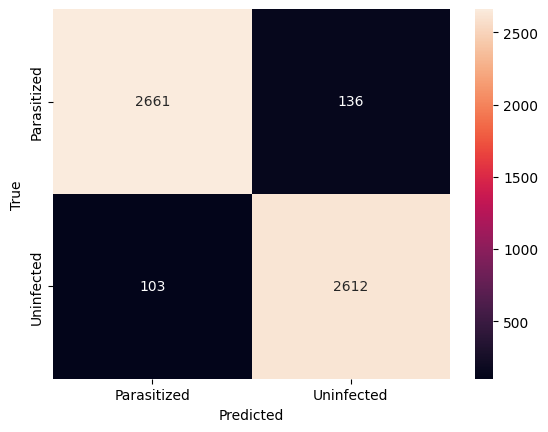

In [8]:
class MalariaCNN(nn.Module):
    def __init__(self):
        super(MalariaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 15 * 15, 512)  
        self.fc2 = nn.Linear(512, 2)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 15 * 15)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MalariaCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Training the model
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

print("Finished Training")

# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Epoch 1, Train Loss: 0.26892143953997094, Valid Loss: 0.1503240897217927, Train Acc: 0.8884604916991744, Valid Acc: 0.9555515239477503
Epoch 2, Train Loss: 0.1422381432745903, Valid Loss: 0.1377749325562204, Train Acc: 0.9544588587498866, Valid Acc: 0.9573657474600871
Epoch 3, Train Loss: 0.12680521307929443, Valid Loss: 0.13085831864871558, Train Acc: 0.9582237140524358, Valid Acc: 0.9589985486211902
Epoch 4, Train Loss: 0.11789402225242687, Valid Loss: 0.1268108409393385, Train Acc: 0.9608999364964166, Valid Acc: 0.9589985486211902
Epoch 5, Train Loss: 0.10007737432903893, Valid Loss: 0.13343324557463557, Train Acc: 0.9665698993014605, Valid Acc: 0.9582728592162555
Epoch 6, Train Loss: 0.0837038818919823, Valid Loss: 0.15343154777807716, Train Acc: 0.9703347546040098, Valid Acc: 0.95355587808418
Epoch 7, Train Loss: 0.07341575162946172, Valid Loss: 0.15500648563587768, Train Acc: 0.9739635307992379, Valid Acc: 0.9533744557329463
Epoch 8, Train Loss: 0.03998616833217153, Valid Loss: 0

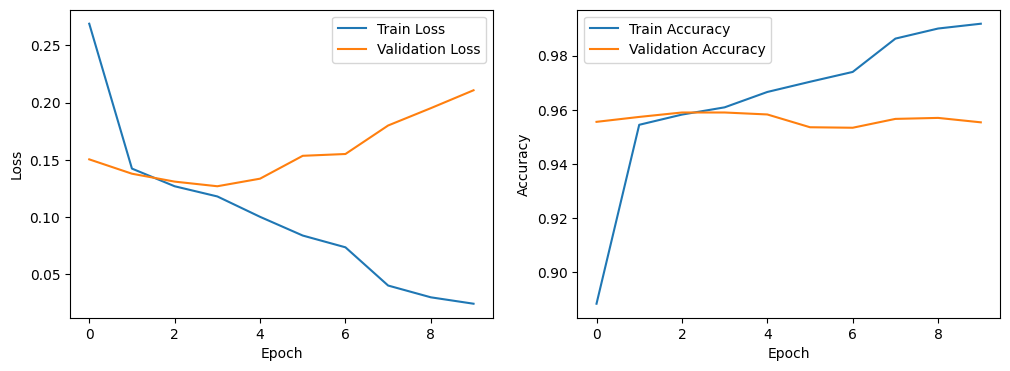

In [12]:
class MalariaCNN(nn.Module):
    def __init__(self):
        super(MalariaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 15 * 15, 512) 
        self.fc2 = nn.Linear(512, 2) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 15 * 15)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

model = MalariaCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / len(trainloader))
    train_accuracies.append(correct / total)

    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    valid_losses.append(valid_loss / len(testloader))
    valid_accuracies.append(correct / total)

    scheduler.step()
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Valid Loss: {valid_losses[-1]}, Train Acc: {train_accuracies[-1]}, Valid Acc: {valid_accuracies[-1]}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
